In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  ! gdown --id '11Aef2VTtCYCDkgdNsF7ckXod9AbRHH8I' --output ABIDE_mask.zip
  !unzip "/content/ABIDE_mask.zip"

Fri Apr 21 11:47:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset

class FMRI_Dataset(Dataset):

    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        self.asd_dir = os.path.join(root_dir, split, 'ASD')
        self.td_dir = os.path.join(root_dir, split, 'TD')
        
        self.asd_files = os.listdir(self.asd_dir)
        self.td_files = os.listdir(self.td_dir)
        self.file_list = self.asd_files + self.td_files
        self.labels = [0] * len(self.asd_files) + [1] * len(self.td_files)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        if self.labels[index] == 0:
            file_path = os.path.join(self.asd_dir, file_name)
        else:
            file_path = os.path.join(self.td_dir, file_name)

        img = nib.load(file_path).get_fdata()
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return img, label

root_dir = os.path.join("/content/mask_split")
split_dir = os.path.join(root_dir)  
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")

train_dataset = FMRI_Dataset(root_dir=split_dir, split='train')
valid_dataset = FMRI_Dataset(root_dir=split_dir, split='valid')
# test_dataset = FMRI_Dataset(root_dir=split_dir, split='test')

In [2]:
"""
This is the c3d implementation with batch norm.

References
----------
[1] Tran, Du, et al. "Learning spatiotemporal features with 3d convolutional networks." 
Proceedings of the IEEE international conference on computer vision. 2015.
"""

import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial


class C3D(nn.Module):
    def __init__(self,
                 sample_size,
                 sample_duration,
                 num_classes=600):

        super(C3D, self).__init__()
        self.group1 = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        self.group2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group5 = nn.Sequential(
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1)))

        last_duration = int(math.floor(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.fc1 = nn.Sequential(
            nn.Linear((512 * last_duration * last_size * last_size) , 4096),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc = nn.Sequential(
            nn.Linear(4096, num_classes))         

        

    def forward(self, x):
        out = self.group1(x)
        out = self.group2(out)
        out = self.group3(out)
        out = self.group4(out)
        out = self.group5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc(out)
        return out


def get_fine_tuning_parameters(model, ft_portion):
    if ft_portion == "complete":
        return model.parameters()

    elif ft_portion == "last_layer":
        ft_module_names = []
        ft_module_names.append('fc')

        parameters = []
        for k, v in model.named_parameters():
            for ft_module in ft_module_names:
                if ft_module in k:
                    parameters.append({'params': v})
                    break
            else:
                parameters.append({'params': v, 'lr': 0.0})
        return parameters

    else:
        raise ValueError("Unsupported ft_portion: 'complete' or 'last_layer' expected")


def get_model(**kwargs):
    """
    Returns the model.
    """
    model = C3D(**kwargs)
    return model


if __name__ == '__main__':
    model = get_model(sample_size = 61, sample_duration = 73, num_classes=600)
    # model = model.cuda()
    model = nn.DataParallel(model, device_ids=None)
    print(model)

    input_var = Variable(torch.randn(8, 3, 16, 112, 112))
    output = model(input_var)
    print(output.shape)

DataParallel(
  (module): C3D(
    (group1): Sequential(
      (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (group2): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (group3): Sequential(
      (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Epoch 1/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch 2/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

Epoch 3/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

Epoch 4/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch 5/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

Epoch 6/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 7/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Epoch 8/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

Epoch 9/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch 10/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Epoch 11/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 12/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 13/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 14/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

Epoch 15/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 16/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 17/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 18/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

Epoch 19/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

Epoch 20/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 21/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

Epoch 22/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Epoch 23/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 24/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch 25/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

Epoch 26/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch 27/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch 28/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Epoch 29/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 30/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

Epoch 31/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch 32/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

Epoch 33/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 34/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

Epoch 35/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 36/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

Epoch 37/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Epoch 38/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 39/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Epoch 40/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch 41/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Epoch 42/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 43/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 44/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 45/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Epoch 46/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Epoch 47/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 48/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

Epoch 49/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 50/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Epoch 51/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 52/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 53/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 54/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

Epoch 55/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

Epoch 56/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 57/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Epoch 58/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch 59/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Epoch 60/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 61/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch 62/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Epoch 63/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

Epoch 64/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Epoch 65/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 66/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Epoch 67/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch 68/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 69/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 70/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Epoch 71/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Epoch 72/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 73/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 74/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 75/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 76/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 77/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Epoch 78/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 79/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 80/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

Epoch 81/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Epoch 82/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 83/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch 84/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

Epoch 85/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch 86/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

Epoch 87/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

Epoch 88/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Epoch 89/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 90/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

Epoch 91/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

Epoch 92/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

Epoch 93/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

Epoch 94/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 95/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Epoch 96/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

Epoch 97/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 98/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch 99/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Epoch 100/100, Loss: 0.6931,Acc:0.49514563106796117


Validation accuracy: 0.5000


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


Test Loss: 0.6931, Test Acc: 0.4944


TypeError: ignored

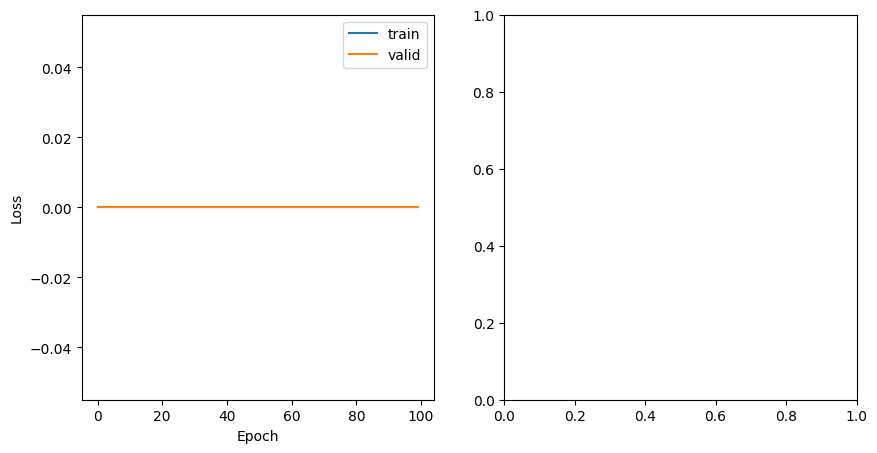

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
num_epochs = 50
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            loss = criterion(outputs, label)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


# Step 5: 模型保存
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)

# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')
plt.show()